In [13]:
import os
import sys
from  datetime import datetime
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import f1_score, classification_report, roc_auc_score, precision_score, confusion_matrix,roc_curve,precision_recall_curve,accuracy_score,recall_score
import numpy as np
import pandas as pd
import joblib
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier
import logging



In [14]:
# Configure Logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("../logs/model_building.log"),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)



In [15]:
# Configurations
class Config:
    DATA_PATH = "../data/processed_data/card_transdata.csv"
    MODELS_DIR = "../weights/models/"
    REPORTS_DIR = "../reports/"
    SEED = 42
    TEST_SIZE = 0.2
    SCORING = 'f1_weighted'
    FIG_SIZE = (10, 6)
    CV_FOLDS = 10



In [16]:
config = Config()

os.makedirs(config.MODELS_DIR, exist_ok=True)
os.makedirs(config.REPORTS_DIR, exist_ok=True)

np.random.seed(config.SEED)

In [17]:
# ==============================
# 2. Data Loading
# ==============================

def load_data(filepath: str) -> pd.DataFrame:
    """Load preprocessed sentiment data."""
    try:
        df = pd.read_csv(filepath)
        logger.info(f"Data loaded with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except Exception as e:
        logger.error(f"Error loading dataset: {str(e)}")
        raise

In [18]:
df = load_data(config.DATA_PATH)
df.head(2)

2025-05-01 18:57:05,972 - INFO - Data loaded with 1000000 rows and 8 columns


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.477882,-0.182849,0.043491,0.366584,1.361576,-0.334458,-1.364425,0.0
1,-0.241607,-0.188094,-0.189300,0.366584,-0.734443,-0.334458,-1.364425,0.0


In [19]:
def prepare_features(df:pd.DataFrame)->Tuple[pd.DataFrame,pd.Series]:
    '''Separate features and labels from the dataset'''
    logger.info("Preparing features and labels from the dataset")
    X=df.drop(columns=['fraud'])
    y=df['fraud']
    return X,y

2025-05-01 18:57:06,101 - INFO - Preparing features and labels from the dataset
2025-05-01 18:57:06,187 - INFO - X_train shape: (800000, 7), Test size: (200000, 7)


(1000000,)

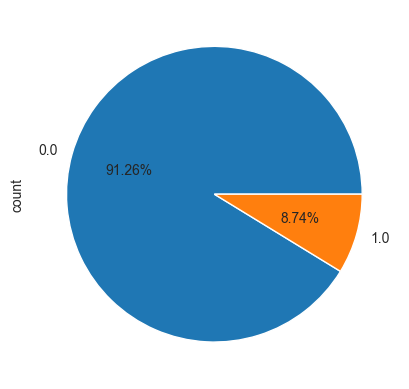

In [20]:
X, y = prepare_features(df)
y.value_counts().plot.pie(autopct='%0.2f%%')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config.TEST_SIZE, random_state=config.SEED)

logger.info(f"X_train shape: {X_train.shape}, Test size: {X_test.shape}")
y.shape

In [21]:
# ==============================
# 5. Model Initialization
# ==============================

def initialize_models() -> Dict[str, BaseEstimator]:
    """Initialize machine learning models."""
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=config.SEED,n_jobs=-1),
        "XGBoost": XGBClassifier(n_estimators=100, random_state=config.SEED, eval_metric="mlogloss",n_jobs=-1,tree_method="hist"),
        "LightGBM": LGBMClassifier(n_estimators=100, random_state=config.SEED, class_weight="balanced",n_jobs=-1),
    }
    return models


In [22]:
# ==============================
# 6. Model Training and Evaluation
# ==============================

def evaluate_model(model: Pipeline, X_test: pd.DataFrame, y_test: np.ndarray) -> Dict[str, float]:
    """Evaluate model on test data."""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted"),
        "recall": recall_score(y_test, y_pred, average="weighted"),
        "f1_weighted": f1_score(y_test, y_pred, average="weighted"),
    }
    if y_test.ndim == 2 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)
    if y_prob is not None:
        metrics["roc_auc_ovr"] = roc_auc_score(y_test, y_prob[:,1], multi_class="ovr", average="weighted")

    return metrics

def train_and_evaluate_models(X_train: pd.DataFrame, y_train: np.ndarray,
                              X_test: pd.DataFrame, y_test: np.ndarray) -> Dict[str, Dict]:
    """Train and evaluate all models."""
    results = {}
    models = initialize_models()

    for name, model in models.items():
        logger.info(f"Training {name}...")
        pipeline = Pipeline([
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)

        cv_score = cross_val_score(pipeline, X_train, y_train, cv=config.CV_FOLDS, scoring=config.SCORING)
        metrics = evaluate_model(pipeline, X_test, y_test)

        results[name] = {
            "model": pipeline,
            "cv_mean": np.mean(cv_score),
            "cv_std": np.std(cv_score),
            "test_metrics": metrics
        }

        # Confusion matrix
        plot_confusion_matrix(pipeline, X_test, y_test, model_name=name)
        plot_roc_curve(pipeline, X_test, y_test, model_name=name)
        plot_precision_recall_curve(pipeline, X_test, y_test, model_name=name)

    return results

def plot_confusion_matrix(model: Pipeline, X_test: pd.DataFrame, y_test: np.ndarray, model_name: str) -> None:
    """Plot confusion matrix."""
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=config.FIG_SIZE)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"{config.REPORTS_DIR}/confusion_matrix_{model_name.replace(' ', '_')}.png")
    plt.close()

def plot_roc_curve(model: Pipeline, X_test: pd.DataFrame, y_test: np.ndarray, model_name: str) -> None:
    """Plot ROC curve."""
    preds = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, preds)
    plt.figure(figsize=config.FIG_SIZE)
    plt.plot(fpr, tpr, label=f"{model_name}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.tight_layout()
    plt.savefig(f"{config.REPORTS_DIR}/roc_curve_{model_name.replace(' ', '_')}.png")
    plt.close()

def plot_precision_recall_curve(model: Pipeline, X_test: pd.DataFrame, y_test: np.ndarray, model_name: str) -> None:
    """Plot precision-recall curve."""
    preds = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, preds)
    plt.figure(figsize=config.FIG_SIZE)
    plt.plot(recall, precision, label=f"{model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.tight_layout()
    plt.savefig(f"{config.REPORTS_DIR}/precision_recall_curve_{model_name.replace(' ', '_')}.png")
    plt.close()


In [23]:

# ==============================
# 7. Model Selection and Saving
# ==============================

def select_best_model(results: Dict[str, Dict]) -> Tuple[str, Pipeline]:
    """Select the best performing model."""
    summary = pd.DataFrame({
        "Model": list(results.keys()),
        "CV_Mean": [v['cv_mean'] for v in results.values()],
        "CV_Std": [v['cv_std'] for v in results.values()],
        "Test_precision": [v['test_metrics']['precision'] for v in results.values()],
        "Test_recall": [v['test_metrics']['recall'] for v in results.values()],
        "Test_F1": [v['test_metrics']['f1_weighted'] for v in results.values()]
    }).sort_values(by="CV_Mean", ascending=False)

    logger.info("\n" + str(summary))
    summary.to_csv(f"{config.REPORTS_DIR}/model_comparison.csv", index=False)

    best_model_name = summary.iloc[0]["Model"]
    best_model = results[best_model_name]["model"]

    return best_model_name, best_model

def save_model(model: Pipeline, model_name: str) -> None:
    """Save the model."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = f"{config.MODELS_DIR}/{model_name.replace(' ', '_').lower()}_{timestamp}.pkl"

    with open(path, "wb") as f:
        joblib.dump(model, f)

    logger.info(f"Model saved at {path}")




In [24]:
# ==============================
# 8. Final Execution
# ==============================

results = train_and_evaluate_models(X_train, y_train, X_test, y_test)
best_model_name, best_model = select_best_model(results)
save_model(best_model, best_model_name)

print("\n" + "="*80)
print(f"BEST MODEL: {best_model_name}")
print("="*80)


2025-05-01 18:57:06,443 - INFO - Training Random Forest...
2025-05-01 18:58:33,531 - INFO - Training XGBoost...
2025-05-01 18:58:46,471 - INFO - Training LightGBM...
[LightGBM] [Info] Number of positive: 69960, number of negative: 730040
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 62964, number of negative: 657036
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

In [25]:
import os
import pickle

def save_best_clean_model(best_model, best_model_name: str) -> None:
    """
    Save the best model from clean data into ../models directory with dynamic name.

    Args:
        best_model: Trained best model object
        best_model_name (str): Name of the best model (lowercase, spaces replaced with '_')
    """
    # 1. Format model name
    model_name_clean = best_model_name.lower().replace(' ', '_')

    # 2. Prepare file path
    save_path = f"../weights/models/best_model_{model_name_clean}.pkl"

    # 3. Ensure directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # 4. Save model
    with open(save_path, 'wb') as f:
        pickle.dump(best_model, f)

    print(f"✅ Best model saved successfully at: {save_path}")

# ===========================
# Example Usage (Your Part)
# ===========================

# Suppose you already have the following variables from your model selection step:
# best_model_name = "Logistic Regression"
# best_model = <your trained Logistic Regression model object>

# Now directly call:
save_best_clean_model(best_model, best_model_name)


✅ Best model saved successfully at: ../weights/models/best_model_random_forest.pkl


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

xgb_clf = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=91,  # you can adjust based on your dataset imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    tree_method='hist',      # << Use GPU for training
    device='cuda'
)

param_grid={
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
    }

f1 = make_scorer(f1_score)
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring=f1, n_jobs=-1,verbose=2)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_:.4f}")

# Evaluate on Test
y_pred = best_xgb.predict(X_test)
test_f1 = f1_score(y_test, y_pred)

print(f"Test F1 Score: {test_f1:.4f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/home/ranbir/Projects/credit_card_fraud_detection/venv/lib/python3.12/site-packages/xgboost/core.py:772: UserWarning: [18:59:10] WARNING: /home/ranbir/xgboost/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/ranbir/Projects/credit_card_fraud_detection/venv/lib/python3.12/site-packages/xgboost/core.py:772: UserWarning: [18:59:11] WARNING: /home/ranbir/xgboost/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions